In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from keras.models import Sequential
from keras.layers import LSTM,Dense, GRU, SimpleRNN
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

plt.rcParams["figure.figsize"] = (12,8)

In [2]:
home_path = os.getenv('HOME')
df = pd.read_csv(f"{home_path}/Documents/tables/level477.csv", sep=';')
df["ev_name"] = df.ev_name.apply(lambda x: x.strip().lower())
df = df[df.ev_name == "фактический остаток"]
df["event_dt"] = df.apply(lambda x: datetime.strptime(x.lv_evdate.replace('00:00:00+00', x.lv_evtime), "%Y-%m-%d %H:%M:%S"), axis=1)
df["shift_dt"] = df.apply(lambda x: datetime.strptime(x.lv_smdate.replace('00:00:00+00', x.lv_smtime), "%Y-%m-%d %H:%M:%S"), axis=1)

In [3]:
df.drop(["lv_smazs", "lv_evdate", "lv_evtime", "lv_smdate", "lv_smtime", "ev_name"], axis=1, inplace=True)

In [4]:
df = df.drop(df[df.lv_volume > 100000].index)

In [12]:
df.head(3)

,lv_density,lv_temp,lv_level,lv_massa,lv_volume,lv_tank,lv_prod_cod,event_dt,shift_dt
0,0.8203,20.3,1487.0,6371.27,7767.0,1,51,2023-06-20 00:00:40,2023-06-20 00:00:43
1,0.7287,18.0,1862.0,14713.91,20192.0,3,92,2023-06-20 00:00:41,2023-06-20 00:00:43
2,0.7398,19.8,1816.0,7096.16,9592.0,2,95,2023-06-20 00:00:41,2023-06-20 00:00:43


<Axes: xlabel='event_dt', ylabel='lv_volume'>

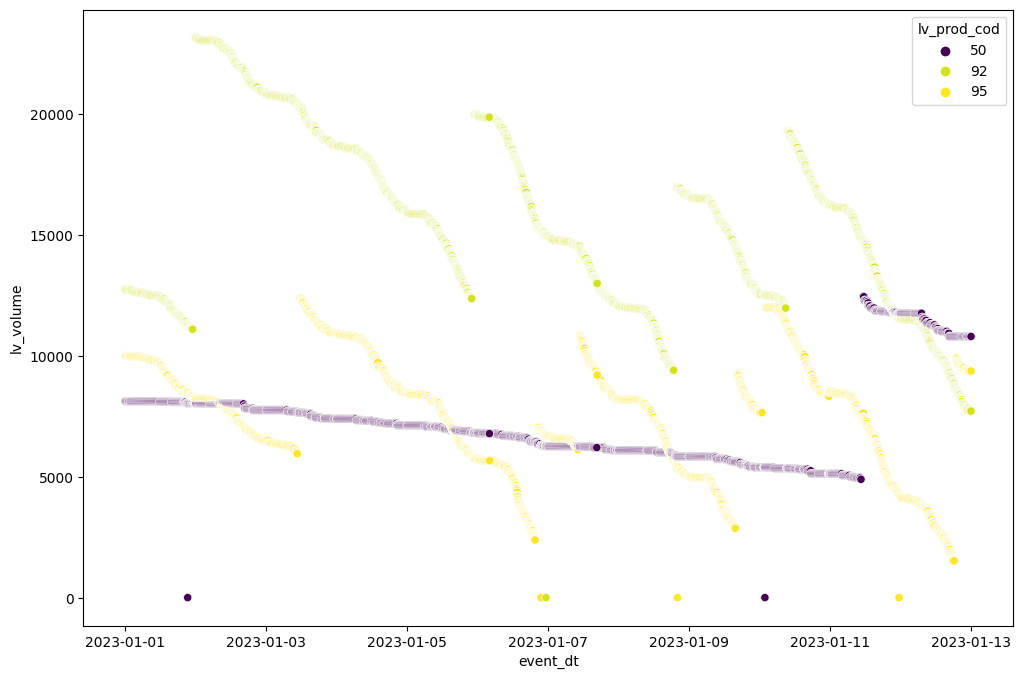

In [13]:
sns.scatterplot(data=df[df.event_dt <= "2023-01-13"], x="event_dt", y="lv_volume", hue="lv_prod_cod", palette="viridis")

In [5]:
df.drop(df[df.lv_volume == 0].index, inplace=True)

In [6]:
df95 = df[df.lv_prod_cod == 95].copy()

In [7]:
df95.lv_volume.min()

1394.0

In [8]:
df95 = df95.sort_values('event_dt').reset_index(drop=True)

In [9]:
mid_drain_states = []
state = []
prev_value = None
for i, row in df95.iterrows():
    value = row.lv_volume
    if i:
        if value - prev_value > 500:
            mid_drain_states.append(state)
            state = []
    state.append((value, row.event_dt))
    prev_value = value
        

In [10]:
max_count = 0
delays = []
for state in mid_drain_states:
    for i, measure in enumerate(state):
        count = 0
        base_value = measure[0]
        for k in range(i + 1, len(state)):
            if state[k][0] == base_value:
                count += 1
            elif state[k][0] < base_value:
                break
        delays.append(count + 1)
        if count > max_count:
            max_count = count
max_count

30

In [11]:
# расчет средних расходов каждые k замеров за один межсливный период 
exp_data = []
k_skip = 10
for state in mid_drain_states:
    prev_value = state[0][0]
    prev_event_dt = state[0][1]
    for i, measure in enumerate(state):
        if i and i % k_skip == 0 or i + 1 == len(state):
            value = measure[0]
            event_dt = measure[1]
            diff_level = prev_value - value
            diff_hours = (event_dt - prev_event_dt).seconds / 3600
            prev_value = value
            prev_event_dt = event_dt
            exp_data.append((diff_level, diff_hours, event_dt))
            
df95_exp = pd.DataFrame(exp_data, columns=["diff_level", "diff_hours", "event_dt"])
df95_exp["expense_per_hours"] = df95_exp.diff_level / df95_exp.diff_hours
q_high = df95_exp.expense_per_hours.quantile(0.95)
df95_exp_cleaned = df95_exp[(df95_exp.expense_per_hours >= 0) & (df95_exp.expense_per_hours < q_high)]

train_df = df95_exp_cleaned[["expense_per_hours"]]
df95_exp_cleaned.shape, q_high

((9276, 4), 526.6195850018198)

<Axes: xlabel='event_dt', ylabel='expense_per_hours'>

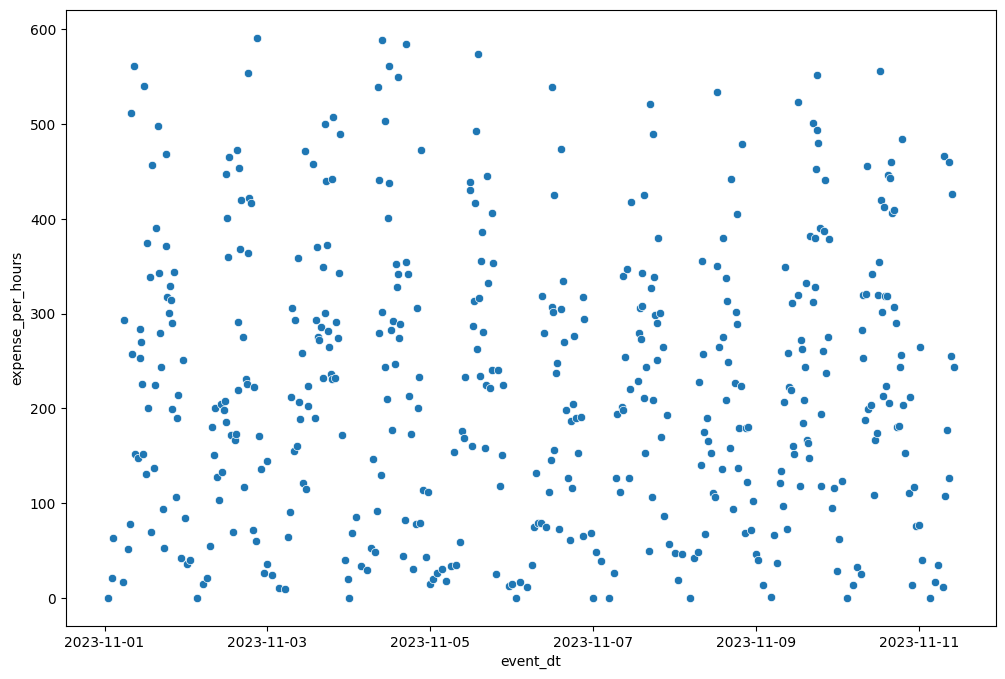

In [77]:
sns.scatterplot(data=df95_exp_cleaned[df95_exp_cleaned.event_dt >= "2023-11-01"], x="event_dt", y="expense_per_hours")


In [12]:
# расчет средних расходов каждые k замеров за один межсливный период 
exp_data_by_day = []
for state in mid_drain_states:
    prev_value = state[0][0]
    prev_event_dt = state[0][1]
    for i, measure in enumerate(state):
        event_dt = measure[1]
        if i and event_dt.date() != prev_event_dt.date() or i + 1 == len(state):
            value = measure[0]
            diff_level = prev_value - value
            diff_hours = (event_dt - prev_event_dt).seconds / 3600
            prev_value = value
            prev_event_dt = event_dt
            exp_data_by_day.append((diff_level, diff_hours, event_dt.replace(hour=0, minute=0, second=0)))

In [147]:
df95_by_day = pd.DataFrame(exp_data_by_day, columns=["diff_level", "diff_hours", "event_dt"]).groupby("event_dt").agg(
    diff_level=pd.NamedAgg(column="diff_level", aggfunc="sum"),
    diff_hours=pd.NamedAgg(column="diff_hours", aggfunc="sum"),
)
df95_by_day["expense_per_hours"] = df95_by_day.diff_level / df95_by_day.diff_hours
df95_by_day.reset_index(inplace=True)

In [148]:
df95_by_day = df95_by_day[df95_by_day.expense_per_hours < np.quantile(df95_by_day.expense_per_hours, 0.95)]

In [13]:
def process_data(data, window_width):
    x, y = [], []
    for i in range(len(data) - window_width - 1):
        x.append(data[i:(i+window_width), 0])
        y.append(data[(i+window_width), 0])
    return np.array(x),np.array(y)


In [88]:

scl = MinMaxScaler()
cl = scl.fit_transform(train_df)

window_width = 90
X,y = process_data(cl, window_width)

X_train,X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train,y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]

print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])

7348
1837
7348


In [89]:
model = Sequential()
model.add(LSTM(64, input_shape=(window_width, 1), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

#Fit model with history to check for overfitting
history = model.fit(
    X_train,
    y_train,
    epochs=25,
    validation_data=(X_test, y_test),
    shuffle=False
)

Epoch 1/25
230/230 [==============================] - 25s 95ms/step - loss: 0.0532 - val_loss: 0.0484
Epoch 2/25
230/230 [==============================] - 22s 95ms/step - loss: 0.0452 - val_loss: 0.0461
Epoch 3/25
230/230 [==============================] - 20s 87ms/step - loss: 0.0426 - val_loss: 0.0462
Epoch 4/25
230/230 [==============================] - 21s 90ms/step - loss: 0.0394 - val_loss: 0.0427
Epoch 5/25
230/230 [==============================] - 22s 94ms/step - loss: 0.0387 - val_loss: 0.0432
Epoch 6/25
230/230 [==============================] - 23s 100ms/step - loss: 0.0380 - val_loss: 0.0432
Epoch 7/25
230/230 [==============================] - 23s 99ms/step - loss: 0.0377 - val_loss: 0.0432
Epoch 8/25
230/230 [==============================] - 22s 94ms/step - loss: 0.0374 - val_loss: 0.0433
Epoch 9/25
230/230 [==============================] - 22s 95ms/step - loss: 0.0372 - val_loss: 0.0436
Epoch 10/25
230/230 [==============================] - 22s 94ms/step - loss: 0.03

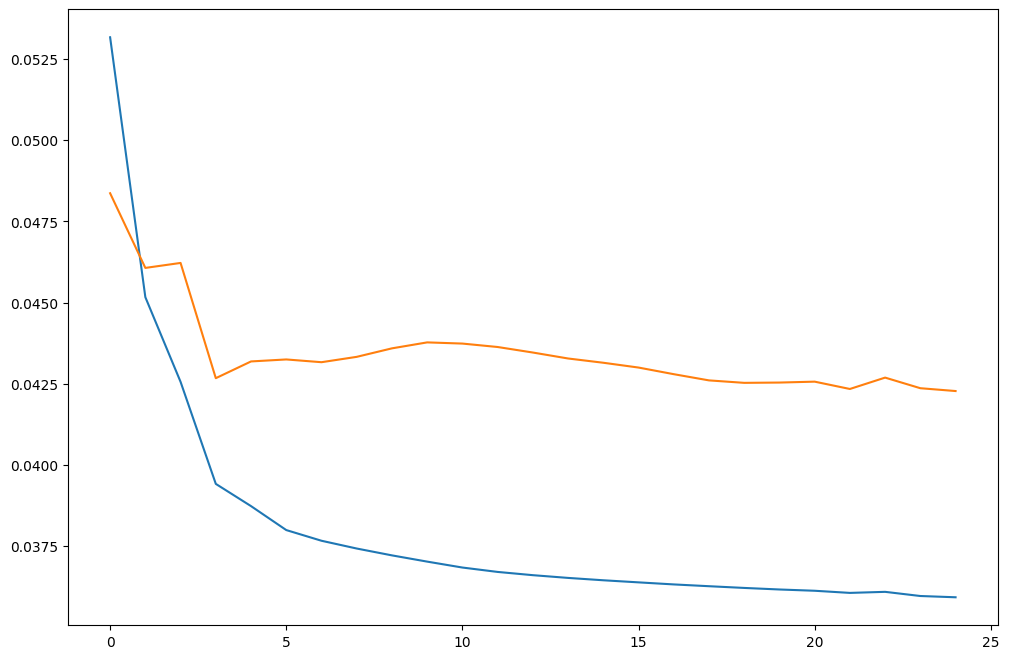

In [90]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [91]:
Xt = model.predict(X_test)
orig_y_test = scl.inverse_transform(y_test.reshape(-1,1))
orig_y_pred = scl.inverse_transform(Xt)
np.sqrt(np.mean((orig_y_test - orig_y_pred) ** 2))

58/58 [==============================] - 3s 31ms/step


108.26670627817575

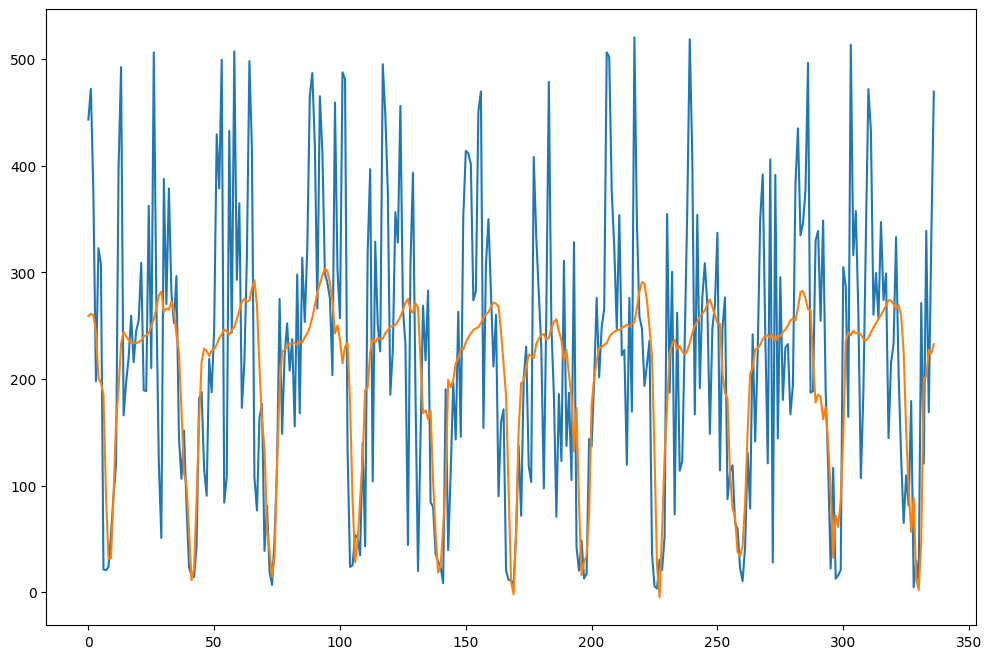

In [92]:
plt.plot(orig_y_test[1500:])
plt.plot(orig_y_pred[1500:])
plt.show()

In [84]:
orig_y_pred.max()

288.40533

In [43]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [161]:
train_df = df95_by_day.expense_per_hours.to_frame()

In [163]:
window_width = 5
X,y = process_data(train_df.values, window_width)

X_train,X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train,y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]

print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])

233
59
233


In [164]:
regressor=xgb.XGBRegressor(eval_metric='rmsle')

#=========================================================================
# exhaustively search for the optimal hyperparameters
#=========================================================================
from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {"max_depth":    [3, 4, 5, 6, 7],
              "n_estimators": [100, 200, 500],
              "learning_rate": [0.01, 0.015]}

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train.reshape(X_train.shape[0], X_train.shape[1]), y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}


In [165]:
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmse')

regressor.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]), y_train)

#=========================================================================
# To use early_stopping_rounds: 
# "Validation metric needs to improve at least once in every 
# early_stopping_rounds round(s) to continue training."
#=========================================================================
# first perform a test/train split 
#from sklearn.model_selection import train_test_split

#X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size = 0.2)
#regressor.fit(X_train, y_train, early_stopping_rounds=6, eval_set=[(X_test, y_test)], verbose=False)

#=========================================================================
# use the model to predict the prices for the test data
#=========================================================================
predictions = regressor.predict(X_test.reshape(X_test.shape[0], X_test.shape[1]))

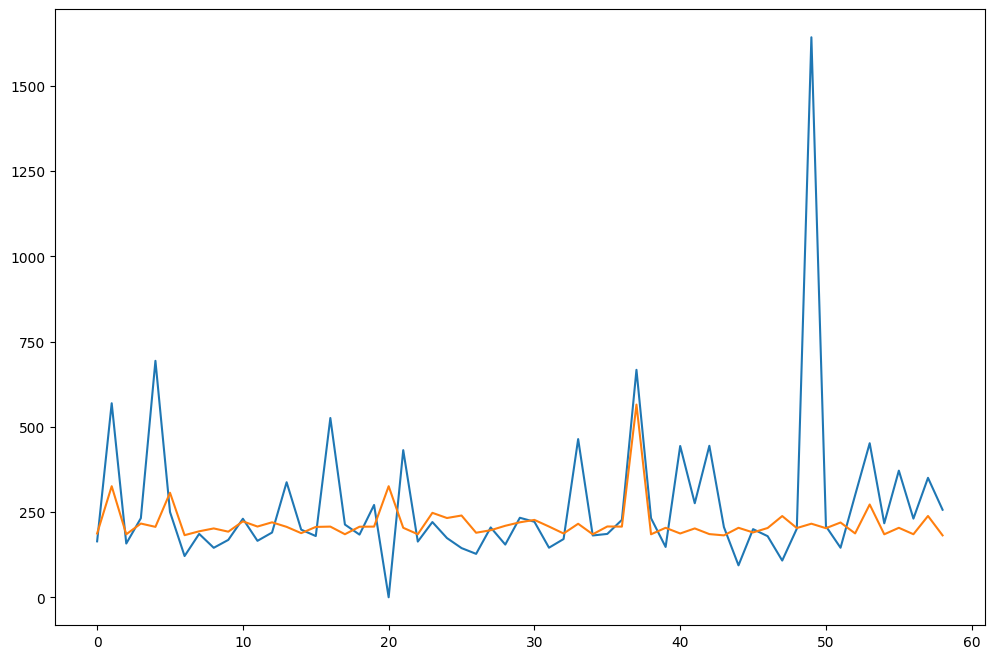

In [166]:

plt.plot(y_test)
plt.plot(predictions)

In [167]:
from sklearn.metrics import mean_squared_error
RMSE = np.sqrt( mean_squared_error(y_test, predictions) )
print("The score is %.5f" % RMSE)

The score is 225.60174


In [195]:
train_df = df95_exp_cleaned[["event_dt", "expense_per_hours"]].set_index("event_dt")

In [196]:
train_df

,expense_per_hours
event_dt,
2023-01-01 01:10:00,8.795505
2023-01-01 03:03:29,12.689088
2023-01-01 05:52:09,6.403162
2023-01-01 07:49:19,32.773826
2023-01-01 09:40:15,45.973558
...,...
2023-11-11 08:40:52,338.879159
2023-11-11 09:05:45,168.787676
2023-11-11 09:42:55,332.556054


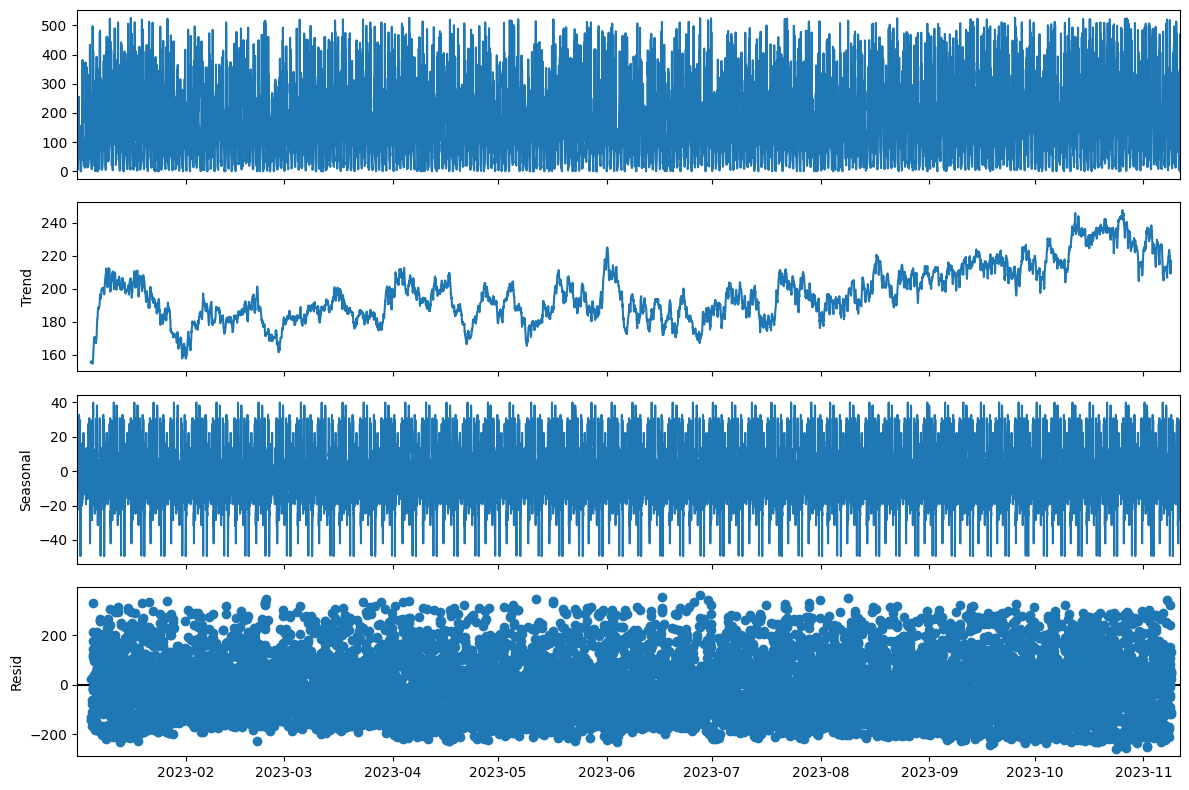

In [202]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df, period=167)
result.plot()
print()

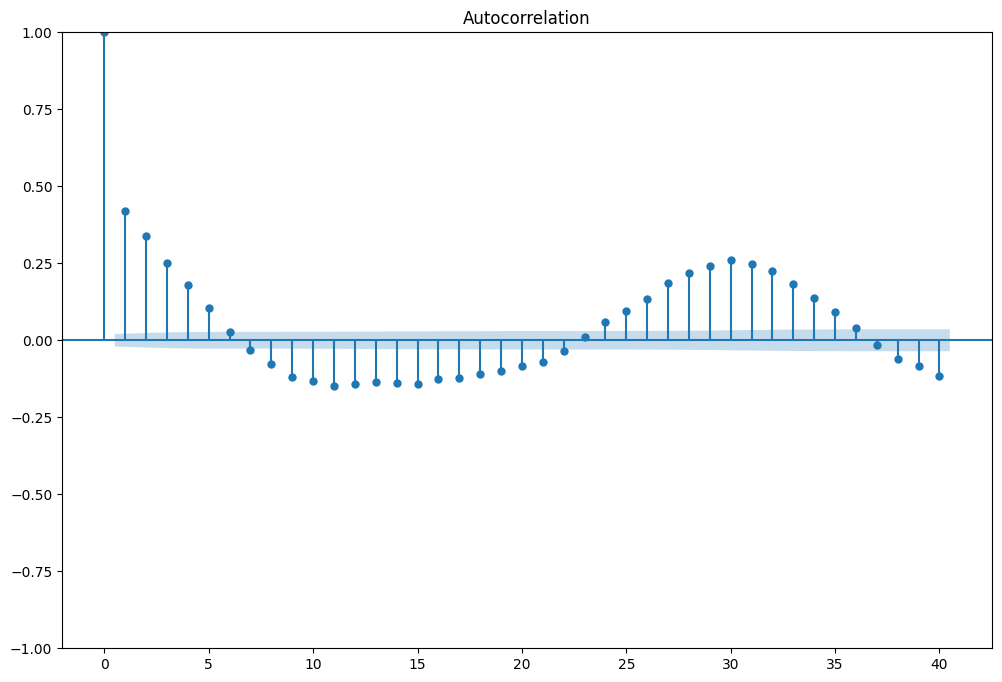

In [204]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train_df)
print()

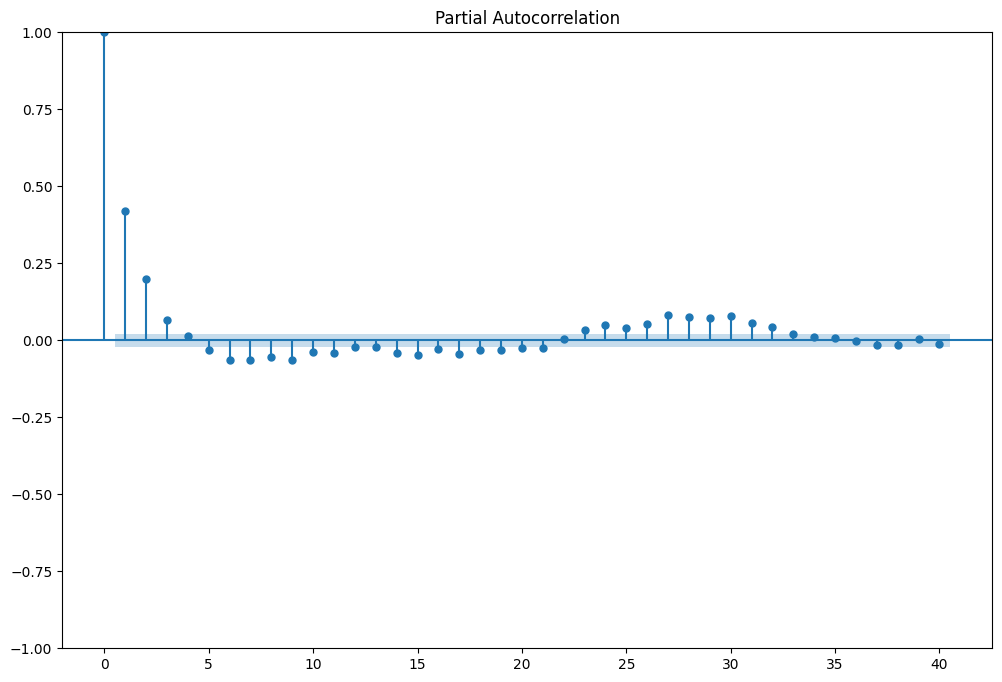

In [208]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_df)
print()

In [209]:
from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(train_df.expense_per_hours.values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -11.935224869775041
ADF p-values: 4.679531725903477e-22
ADF number of lags used: 32
ADF number of observations: 9243
ADF critical values: {'1%': -3.4310576833286595, '5%': -2.8618527511138216, '10%': -2.566936472347253}
ADF best information criterion: 112657.64411632973


In [211]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 2.9 MB/s eta 0:00:003.3 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 1.9 MB/s eta 0:00:00m eta 0:00:010:01:01

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [212]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [214]:
train, test = train_test_split(train_df.expense_per_hours.values, train_size=0.8)

In [95]:
train_data = train_df.expense_per_hours
y = train_df.expense_per_hours.values

<Axes: >

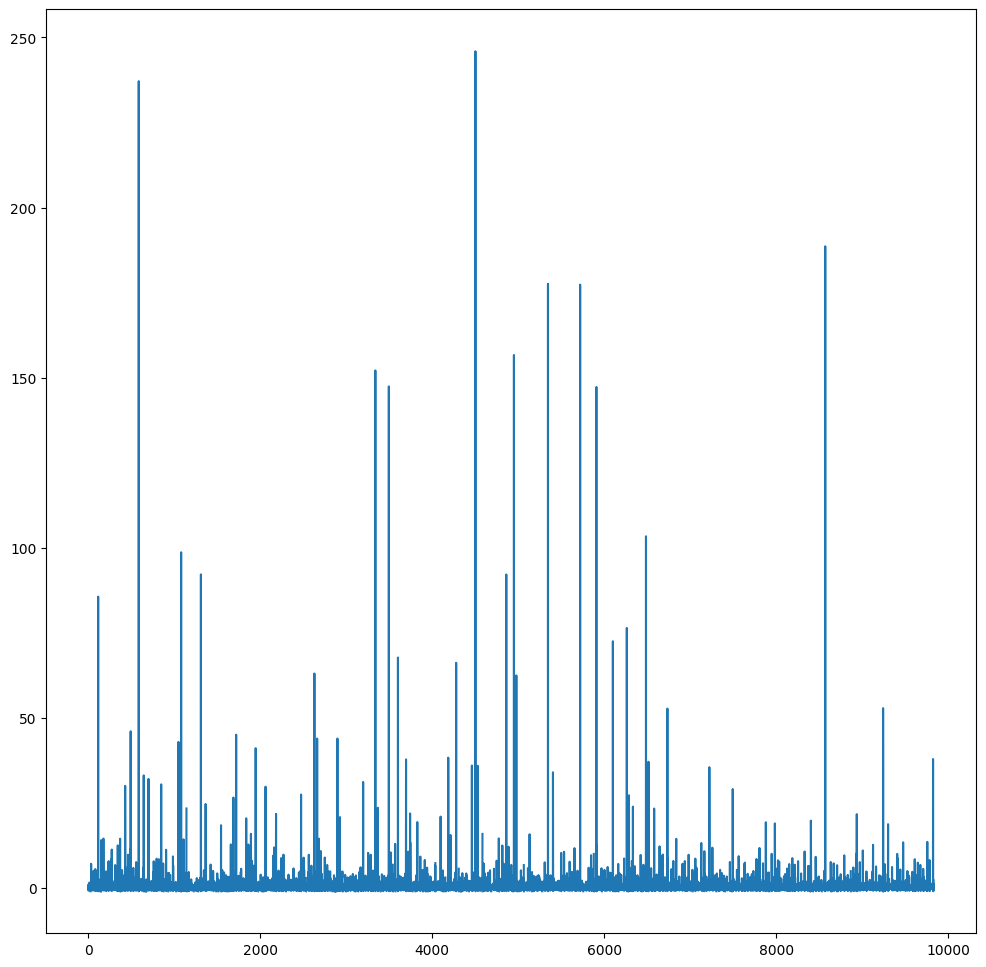

In [87]:
difs = (train_data.shift() - train_data) / train_data
difs = difs.dropna()
difs.plot(figsize=(12, 12))

In [120]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

param_list = [(x, y, z) for x in range(2) for y in range(3) for z in range(4)]


for order in param_list:


 
    # for each param combi do a ts split
    # max 3 months training data
    # 1 day test size

    mses = []

    tscv = TimeSeriesSplit(n_splits=50,
                           max_train_size = 20,
                           test_size=1)
    for train_index, test_index in tscv.split(y):

        train = y[train_index]
        test = y[test_index]

      # for each ts split do a model
        try:
            mod = ARIMA(train, order=order)
            res = mod.fit()
            pred = res.forecast(1)

            mse = mean_squared_error(test, pred)
            mses.append(mse)
        except:
            continue


    average_mse = np.mean(mses)
    std_mse = np.std(mses)
    print(f'Params:{order}; Avg:{average_mse}; Std: {std_mse}')

Params:(0, 0, 0); Avg:32.07643754382135; Std: 201.86175199712892
Params:(0, 0, 1); Avg:35.099582771276744; Std: 201.87614327145107


/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Params:(0, 0, 2); Avg:35.81782262839055; Std: 201.94060654505293


/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn

Params:(0, 0, 3); Avg:39.911414183152104; Std: 202.65296317053077
Params:(0, 1, 0); Avg:65.9028956727663; Std: 293.78476405882174


/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.

Params:(0, 1, 1); Avg:45.1329486305146; Std: 217.73331020959523


/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting pa

Params:(0, 1, 2); Avg:48.48615623673382; Std: 216.6854057660739


/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn

Params:(0, 1, 3); Avg:54.68562076156929; Std: 230.60817495443408


/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Params:(0, 2, 0); Avg:206.84455620453494; Std: 892.1317526737988


/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting pa

Params:(0, 2, 1); Avg:114.13234613892645; Std: 577.4725087313967


/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting pa

Params:(0, 2, 2); Avg:140.07542085466633; Std: 720.0902007782676


/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting pa

Params:(0, 2, 3); Avg:128.23049489410118; Std: 586.0061519640767
Params:(1, 0, 0); Avg:34.34053733618094; Std: 201.3108871042877


/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zer

Params:(1, 0, 1); Avg:35.48523271046523; Std: 199.61131174042816


/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters foun

Params:(1, 0, 2); Avg:35.56623175504818; Std: 200.34547025519208


/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using 

Params:(1, 0, 3); Avg:35.53025026475453; Std: 200.0640761974713


/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary start

Params:(1, 1, 0); Avg:61.41002633436196; Std: 246.45079700447923


/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters foun

Params:(1, 1, 1); Avg:56.317921880714735; Std: 234.43796464246424


/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting pa

Params:(1, 1, 2); Avg:54.02544848079009; Std: 222.92568815867347


/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting pa

Params:(1, 1, 3); Avg:54.42840194332964; Std: 223.61056622639884


/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary start

Params:(1, 2, 0); Avg:129.0636507535144; Std: 483.3357920623663


/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

Params:(1, 2, 1); Avg:133.38351074159738; Std: 593.8630502257587


/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting pa

Params:(1, 2, 2); Avg:143.68181995229463; Std: 627.5138356303814


/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ivan/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retval

Params:(1, 2, 3); Avg:151.57735583621516; Std: 686.8691210819819
